# Evaluation of Automated Recipe Review Models

This notebook analyzes the performance of different automated and manual review approaches on generated medical recipes.
We will load the results, calculate all relevant metrics, and visualize the overlap in errors between the models.

---

In [133]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import numpy as np

# Show all columns in output
pd.set_option('display.max_columns', None)

## 1. Load Data

We load the manually reviewed and automatically reviewed recipe datasets.
Each file contains the field `medische_vraag` (medical question) and a `correct` boolean indicating whether the answer was judged as correct.


In [134]:
# Load datasets
manual = pd.read_json('../data/generated_recipes_manual_review.json', dtype={'correct': 'boolean'})
rag = pd.read_json('../data/generated_recipes_rag_review.json', dtype={'correct': 'boolean'})
moderator = pd.read_json('../data/generated_recipes_moderator_review.json', dtype={'correct': 'boolean'})
combined = pd.read_json('../data/generated_recipes_combined_review.json', dtype={'correct': 'boolean'})

# Consistent column names for different models
rag.rename(columns={'correct': 'correct_rag'}, inplace=True)
moderator.rename(columns={'correct': 'correct_moderator'}, inplace=True)
combined.rename(columns={'correct': 'correct_combined'}, inplace=True)


## 2. Merge All Results

We combine all results into a single DataFrame, using the medical question as the unique identifier.


In [135]:
# Merge on 'medische_vraag'
total = manual.merge(rag[['medische_vraag', 'correct_rag']], on='medische_vraag', how='left')
total = total.merge(moderator[['medische_vraag', 'correct_moderator']], on='medische_vraag', how='left')
total = total.merge(combined[['medische_vraag', 'correct_combined']], on='medische_vraag', how='left')

total.head()


,medicijn,categorie,recept,medische_vraag,patientinformatie,correct,correct_rag,correct_moderator,correct_combined
0,Amoxicilline,Antibioticum,Rp. Amoxicilline 500mg capsules\ndtd. No. 21\n...,Ik heb een keelontsteking. Heb ik antibiotica ...,"Patiënt is 34 jaar, vrouw, heeft koorts, 3 dag...",False,True,True,True
1,nitrofurantoïne,antibioticum,Rp. Nitrofurantoïne 100mg capsules\ndtd. No. 2...,Ik heb blaasontstekingklachten. Wat kan ik daa...,"patiënt is 27 jaar, vrouw, niet zwanger, geen ...",True,True,True,True
2,Levofloxacine,Antibioticum (Fluorochinolon),Rp. Levofloxacine 500mg tabletten\ndtd. No. 7\...,"Ik heb een longontsteking, ik moet antibiotica...","Patiënt, man, 82 jaar oud, COPD, geen penicill...",True,False,True,False
3,Clindamycine,Antibioticum,Rp. Clindamycine 300mg capsules\ndtd. No. XVI\...,Ik heb wondinfectieverschijnselen. Welk antibi...,"Patiënt, man, 56 jaar, geen chronische ziekte,...",True,True,True,True
4,Chloorhexidine,Antisepticum,"Rp. Chloorhexidine 0,2% mondspoeling\ndtd. No....",Ik heb een lichte tandvleesontsteking. Kan ik ...,patiënt is een 69-jarige vrouw zonder chronisc...,True,True,True,True


## 3. Compute Performance Metrics

We calculate the confusion matrix (TP, FP, TN, FN) for each model, as well as precision, recall, accuracy, F1-score, and error rate.


In [136]:
def calc_confusion(true_col, pred_col):
    tp = ((total[true_col] == True) & (total[pred_col] == True)).sum()
    tn = ((total[true_col] == False) & (total[pred_col] == False)).sum()
    fp = ((total[true_col] == False) & (total[pred_col] == True)).sum()
    fn = ((total[true_col] == True) & (total[pred_col] == False)).sum()
    return tp, tn, fp, fn

def calc_metrics(tp, tn, fp, fn):
    total_count = tp + tn + fp + fn
    error_rate = (fp + fn) / total_count if total_count else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    accuracy = (tp + tn) / total_count if total_count else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    return dict(
        error_rate=error_rate,
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1
    )

# Calculate for each model
tp_rag, tn_rag, fp_rag, fn_rag = calc_confusion('correct', 'correct_rag')
tp_mod, tn_mod, fp_mod, fn_mod = calc_confusion('correct', 'correct_moderator')
tp_comb, tn_comb, fp_comb, fn_comb = calc_confusion('correct', 'correct_combined')

metrics = {
    'RAG': calc_metrics(tp_rag, tn_rag, fp_rag, fn_rag),
    'Moderator': calc_metrics(tp_mod, tn_mod, fp_mod, fn_mod),
    'Combined': calc_metrics(tp_comb, tn_comb, fp_comb, fn_comb)
}

# Display summary
pd.DataFrame(metrics).T


,error_rate,precision,recall,accuracy,f1
RAG,0.311558,0.778571,0.778571,0.688442,0.778571
Moderator,0.286432,0.726776,0.950000,0.713568,0.823529
Combined,0.321608,0.787879,0.742857,0.678392,0.764706


## 4. Visualize Confusion Matrices

Let's plot the confusion matrices for each model.


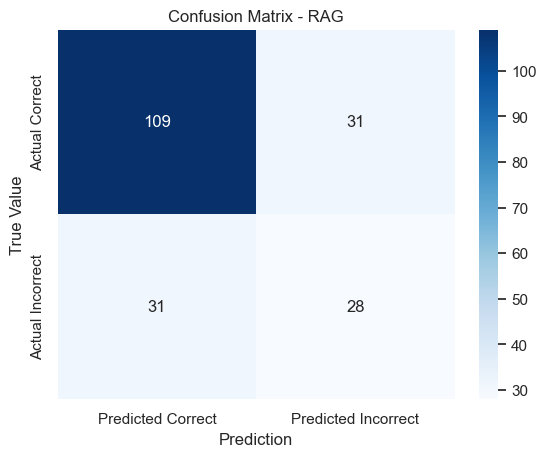

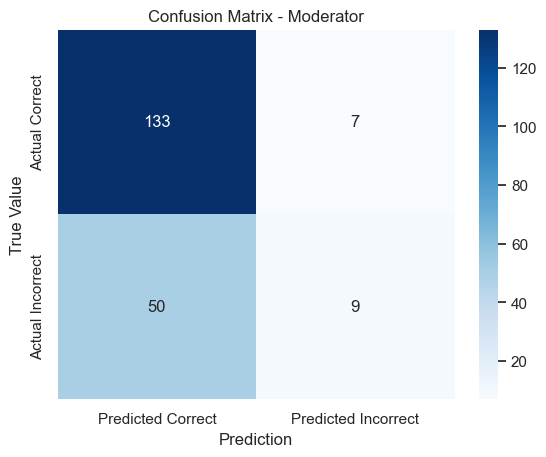

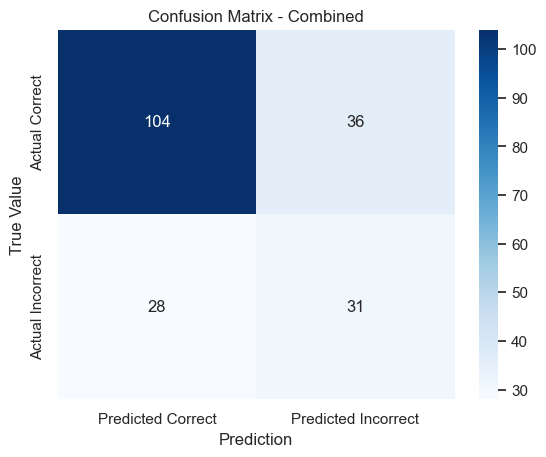

In [137]:
def plot_confusion_matrix(tp, tn, fp, fn, label):
    matrix = np.array([[tp, fn],
                       [fp, tn]])
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Correct', 'Predicted Incorrect'],
                yticklabels=['Actual Correct', 'Actual Incorrect'])
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Prediction")
    plt.ylabel("True Value")
    plt.show()

plot_confusion_matrix(tp_rag, tn_rag, fp_rag, fn_rag, "RAG")
plot_confusion_matrix(tp_mod, tn_mod, fp_mod, fn_mod, "Moderator")
plot_confusion_matrix(tp_comb, tn_comb, fp_comb, fn_comb, "Combined")


## 5. Bar Charts: Model Comparison

Stacked and grouped bar plots for model comparison of TP, FP, TN, FN, and overall metrics.


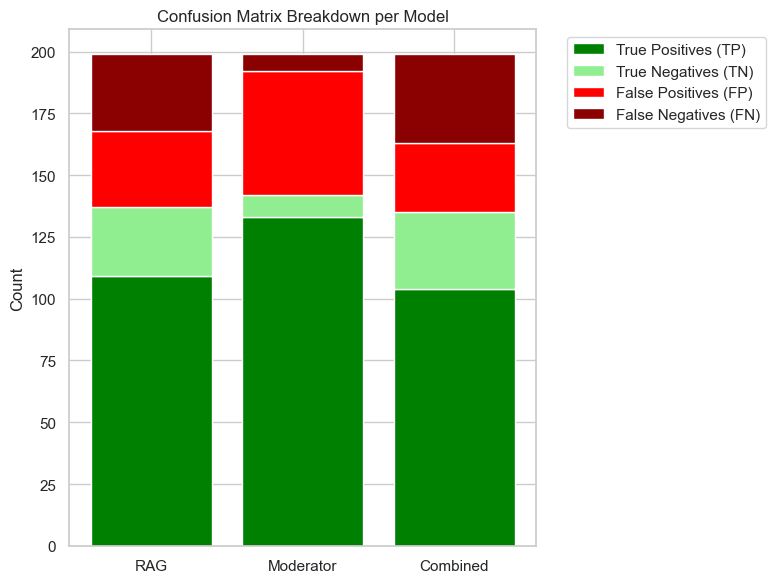

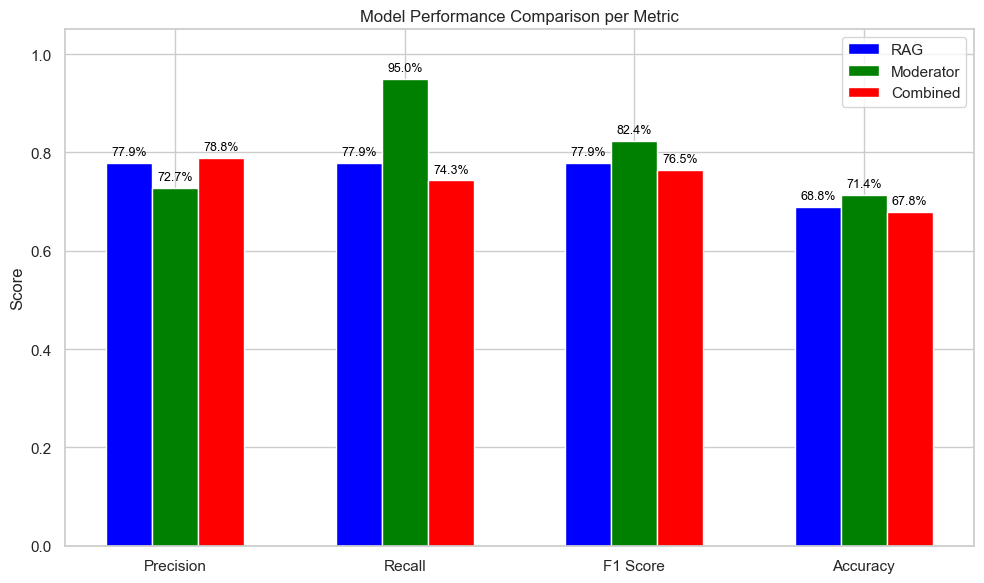

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix values
methods = ['RAG', 'Moderator', 'Combined']
tp_list = [tp_rag, tp_mod, tp_comb]
tn_list = [tn_rag, tn_mod, tn_comb]
fp_list = [fp_rag, fp_mod, fp_comb]
fn_list = [fn_rag, fn_mod, fn_comb]

# --- 1. Stacked bar chart: Confusion matrix counts per model ---
x = np.arange(len(methods))

plt.figure(figsize=(8, 6))
plt.bar(x, tp_list, color='green', label='True Positives (TP)')
plt.bar(x, tn_list, bottom=tp_list, color='lightgreen', label='True Negatives (TN)')
plt.bar(x, fp_list, bottom=[tp + tn for tp, tn in zip(tp_list, tn_list)], color='red', label='False Positives (FP)')
plt.bar(x, fn_list, bottom=[tp + tn + fp for tp, tn, fp in zip(tp_list, tn_list, fp_list)], color='darkred', label='False Negatives (FN)')

plt.xticks(x, methods)
plt.ylabel('Count')
plt.title('Confusion Matrix Breakdown per Model')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# --- 2. Vertical grouped bar chart: Metrics per model, grouped by metric ---

def safe_div(numerator, denominator):
    return numerator / denominator if denominator > 0 else 0

# Calculate metrics for each model
precisions = [safe_div(tp, tp + fp) for tp, fp in zip(tp_list, fp_list)]
recalls = [safe_div(tp, tp + fn) for tp, fn in zip(tp_list, fn_list)]
f1_scores = [safe_div(2 * p * r, p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
accuracies = [safe_div(tp + tn, tp + tn + fp + fn) for tp, tn, fp, fn in zip(tp_list, tn_list, fp_list, fn_list)]

metric_labels = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
metrics_per_model = [precisions, recalls, f1_scores, accuracies]
colors = ['blue', 'green', 'red']
bar_width = 0.2
x_metrics = np.arange(len(metric_labels))

plt.figure(figsize=(10, 6))

for i, (method, color) in enumerate(zip(methods, colors)):
    metric_values = [metric[i] for metric in metrics_per_model]
    plt.bar(x_metrics + i * bar_width, metric_values, bar_width, label=method, color=color)
    for idx, value in enumerate(metric_values):
        plt.text(x_metrics[idx] + i * bar_width, value + 0.01, f"{value*100:.1f}%", ha='center', va='bottom', color='black', fontsize=9)

plt.xticks(x_metrics + bar_width, metric_labels)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.title('Model Performance Comparison per Metric')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 6. Error Overlap Analysis

We analyze which medical questions are incorrectly answered (FP/FN) by which models.
This helps to understand where the models make unique or shared mistakes.


In [139]:
fp_rag_set = set(total[(total['correct'] == False) & (total['correct_rag'] == True)]['medische_vraag'])
fp_mod_set = set(total[(total['correct'] == False) & (total['correct_moderator'] == True)]['medische_vraag'])
fp_comb_set = set(total[(total['correct'] == False) & (total['correct_combined'] == True)]['medische_vraag'])

fn_rag_set = set(total[(total['correct'] == True) & (total['correct_rag'] == False)]['medische_vraag'])
fn_mod_set = set(total[(total['correct'] == True) & (total['correct_moderator'] == False)]['medische_vraag'])
fn_comb_set = set(total[(total['correct'] == True) & (total['correct_combined'] == False)]['medische_vraag'])

# Print overlap summary
print("False Positives (FP) Overlap Summary:")
print({
    "FP unique to RAG": len(fp_rag_set - fp_mod_set - fp_comb_set),
    "FP unique to Moderator": len(fp_mod_set - fp_rag_set - fp_comb_set),
    "FP unique to Combined": len(fp_comb_set - fp_rag_set - fp_mod_set),
    "FP overlap (all)": len(fp_rag_set & fp_mod_set & fp_comb_set)
})

print("False Negatives (FN) Overlap Summary:")
print({
    "FN unique to RAG": len(fn_rag_set - fn_mod_set - fn_comb_set),
    "FN unique to Moderator": len(fn_mod_set - fn_rag_set - fn_comb_set),
    "FN unique to Combined": len(fn_comb_set - fn_rag_set - fn_mod_set),
    "FN overlap (all)": len(fn_rag_set & fn_mod_set & fn_comb_set)
})

def print_question_set(label, s):
    """Print label and set/list, with 'empty' if empty."""
    if not s:
        print(f"  {label}: empty")
    else:
        print(f"  {label}:")
        for v in sorted(s):
            print(f"    - {v}")

print("\n" + "="*50)
print("False Positives (FP) - Detailed Questions")
print("="*50)
print_question_set("Unique to RAG", fp_rag_set - fp_mod_set - fp_comb_set)
print_question_set("Unique to Moderator", fp_mod_set - fp_rag_set - fp_comb_set)
print_question_set("Unique to Combined", fp_comb_set - fp_rag_set - fp_mod_set)
print_question_set("Overlap in all models", fp_rag_set & fp_mod_set & fp_comb_set)

print("\n" + "="*50)
print("False Negatives (FN) - Detailed Questions")
print("="*50)
print_question_set("Unique to RAG", fn_rag_set - fn_mod_set - fn_comb_set)
print_question_set("Unique to Moderator", fn_mod_set - fn_rag_set - fn_comb_set)
print_question_set("Unique to Combined", fn_comb_set - fn_rag_set - fn_mod_set)
print_question_set("Overlap in all models", fn_rag_set & fn_mod_set & fn_comb_set)


False Positives (FP) Overlap Summary:
{'FP unique to RAG': 0, 'FP unique to Moderator': 17, 'FP unique to Combined': 0, 'FP overlap (all)': 26}
False Negatives (FN) Overlap Summary:
{'FN unique to RAG': 2, 'FN unique to Moderator': 0, 'FN unique to Combined': 7, 'FN overlap (all)': 7}

False Positives (FP) - Detailed Questions
  Unique to RAG: empty
  Unique to Moderator:
    - Ik ben vaak wagenziek. Wat helpt echt goed?
    - Ik heb PCOS. Wat zijn mijn medicatieopties?
    - Ik heb astma. Welke inhalatiemedicatie is nodig?
    - Ik heb een helicobacter-infectie. Wat moet ik gebruiken?
    - Ik heb een longontsteking, ik moet antibiotica krijgen, welke?
    - Ik heb een rookershoest. Is er iets dat helpt?
    - Ik heb een vergrote schildklier. Moet ik iets innemen?
    - Ik heb een vroege overgang. Wat kan ik innemen?
    - Ik heb nachtmerries door PTSS. Wat kan ik daarvoor krijgen?
    - Ik heb net een tand getrokken. Moet ik antibiotica gebruiken?
    - Ik heb overgangsklachten. Wat 

## 7. Venn Diagrams of Overlapping Errors

Visualize the overlap of FP and FN errors between models with Venn diagrams.


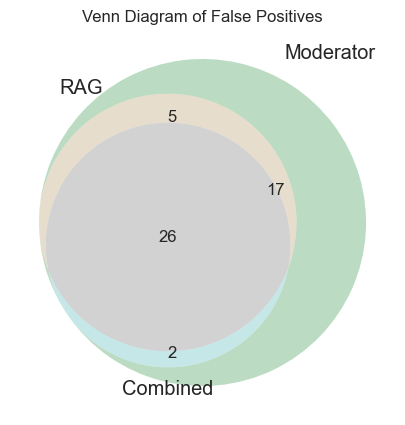

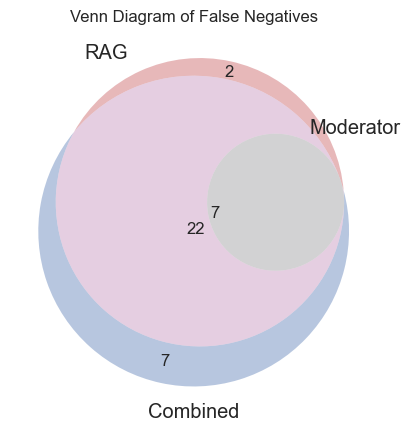

In [140]:
plt.figure(figsize=(10, 5))
plt.title("Venn Diagram of False Positives")
venn3([fp_rag_set, fp_mod_set, fp_comb_set], set_labels=("RAG", "Moderator", "Combined"))
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Venn Diagram of False Negatives")
venn3([fn_rag_set, fn_mod_set, fn_comb_set], set_labels=("RAG", "Moderator", "Combined"))
plt.show()


## Conclusion

- **Moderator** achieves the highest recall (95.0%), meaning it correctly identifies almost all true positives. However, this comes at the cost of precision (72.7%), so it produces more false positives compared to the other models. The Moderator also has the highest F1-score (82.4%) and solid accuracy (71.4%).

- **RAG** is balanced, with precision, recall, and F1-score all at 77.9%. Its accuracy is slightly lower (68.8%), reflecting that it is neither overly cautious nor overly aggressive, but more "conservative" than Moderator in terms of false positives.

- **Combined** has the highest precision (78.8%), but its recall (74.3%) and F1-score (76.5%) are slightly lower than Moderator. Its accuracy (67.8%) is also the lowest of the three, indicating that combining models does not necessarily produce better overall results for this dataset.

**Summary:**
No single approach dominates on all metrics.
- If you value catching every correct answer (high recall), **Moderator** is best, but expect more false positives.
- If you want balanced performance, **RAG** is a safe choice.
- If you prefer to minimize false positives, **Combined** offers the highest precision, but with more missed positives.